In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import TensorBoard

2024-08-16 13:44:23.599090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 13:44:23.599206: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 13:44:23.709768: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define paths
train_dir = '/kaggle/input/dataset-split/Dataset_split/train'
test_dir = '/kaggle/input/dataset-split/Dataset_split/test'
val_dir = '/kaggle/input/dataset-split/Dataset_split/val'


# Data generators
train_data_gen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

valid_data_gen = ImageDataGenerator(
    rescale=1 / 255.0
)

test_data_gen = ImageDataGenerator(
    rescale=1 / 255.0,
)

train_generator = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary'
)

valid_generator = valid_data_gen.flow_from_directory(
    directory="/kaggle/input/dataset-split/Dataset_split/val",
    target_size=(224, 224),
    color_mode="grayscale",
    class_mode="binary",
    batch_size=32,
    shuffle=False
)

test_generator = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',
    class_mode='binary',
    shuffle=False
)
 

for data_batch, labels_batch in train_generator:
    print("Batch of data shape:", data_batch.shape)
    print("Batch of labels shape:", labels_batch.shape)
    break  

Found 14000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 1 classes.
Batch of data shape: (32, 224, 224, 1)
Batch of labels shape: (32,)


# **First Architecture**

In [3]:
def build_cnn_lstm_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))
    
    return model

input_shape = (224, 224, 1)
model = build_cnn_lstm_model(input_shape)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

log_dir = "./"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[tensorboard_callback]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(valid_generator)
print(f'Test accuracy: {test_acc:.4f}')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 12, 384)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143,073 (558.88 KB)

 Trainable params: 143,073 (558.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 162s 349ms/step - accuracy: 0.6352 - loss: 0.6074 - val_accuracy: 0.9553 - val_loss: 0.1594
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 112s 251ms/step - accuracy: 0.9389 - loss: 0.1634 - val_accuracy: 0.9943 - val_loss: 0.0478
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 249ms/step - accuracy: 0.9821 - loss: 0.0609 - val_accuracy: 0.9947 - val_loss: 0.0199
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 250ms/step - accuracy: 0.9910 - loss: 0.0329 - val_accuracy: 0.9983 - val_loss: 0.0087
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 251ms/step - accuracy: 0.9910 - loss: 0.0371 - val_accuracy: 0.9703 - val_loss: 0.1118
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 249ms/step - accuracy: 0.9915 - loss: 0.0305 - val_accuracy: 0.9997 - val_loss: 0.0021
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 109s 246ms/step - accuracy: 0.9935 - loss: 0.0204 - val_accuracy: 0.9983 - val_loss: 0.0072
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 110s 248ms/step - accuracy: 0.9961 - loss: 0.01

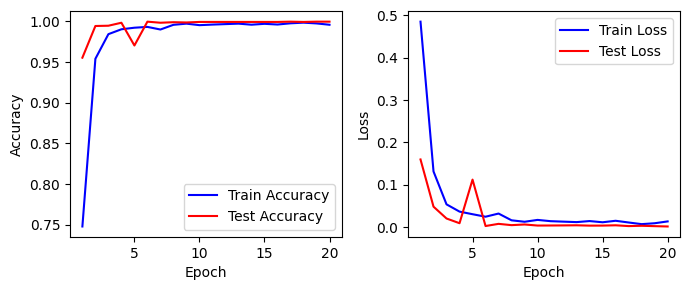

In [4]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step
Confusion Matrix:
[[1499    1]
 [   0 1500]]


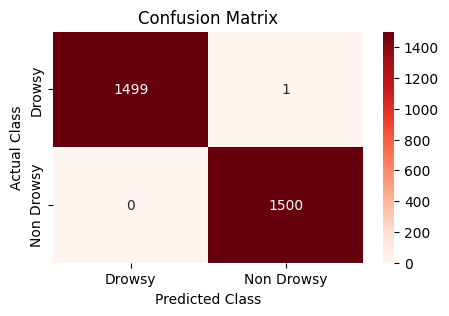


Classification Report:
              precision    recall  f1-score   support

      Drowsy    1.00000   0.99933   0.99967      1500
  Non Drowsy    0.99933   1.00000   0.99967      1500

    accuracy                        0.99967      3000
   macro avg    0.99967   0.99967   0.99967      3000
weighted avg    0.99967   0.99967   0.99967      3000



In [5]:
steps_per_epoch = np.ceil(valid_generator.samples / valid_generator.batch_size).astype(int)
 
# Get predictions from the model
predictions = model.predict(valid_generator, steps=steps_per_epoch)
 
# Since this is a binary classification, we threshold predictions at 0.5
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
 
# Get the true classes
true_classes = valid_generator.classes
 
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_labels = list(valid_generator.class_indices.keys())
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()
 
# Print the classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(valid_generator.class_indices.keys()), digits=5))

In [6]:
model.save('/kaggle/working/cnn_lstm_model.h5')

# **Second Architecture**

In [8]:
def build_cnn_lstm_model2(input_shape):
    model2 = Sequential()

    model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model2.add(MaxPooling2D((2, 2)))
    model2.add(Conv2D(32, (3, 3), activation='relu'))
    model2.add(MaxPooling2D((2, 2)))
    model2.add(Conv2D(32, (3, 3), activation='relu'))
    model2.add(MaxPooling2D((2, 2)))

    model2.add(TimeDistributed(Flatten()))
    
    model2.add(LSTM(64, return_sequences=True))
    model2.add(LSTM(64, return_sequences=False))
    model2.add(Dropout(0.5))

    model2.add(Dense(1, activation='sigmoid'))
    
    return model2

input_shape = (224, 224, 1)
model2 = build_cnn_lstm_model2(input_shape)

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

log_dir = "./"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history2 = model2.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[tensorboard_callback]
)

# Evaluate the model
test_loss, test_acc = model2.evaluate(valid_generator)
print(f'Test accuracy: {test_acc:.4f}')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 26, 832)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 26, 64)         │       229,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,537 (1.07 MB)

 Trainable params: 281,537 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 127s 279ms/step - accuracy: 0.6483 - loss: 0.6049 - val_accuracy: 0.9870 - val_loss: 0.0645
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 249ms/step - accuracy: 0.9607 - loss: 0.1166 - val_accuracy: 0.9983 - val_loss: 0.0084
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 250ms/step - accuracy: 0.9876 - loss: 0.0418 - val_accuracy: 0.9990 - val_loss: 0.0076
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 249ms/step - accuracy: 0.9917 - loss: 0.0277 - val_accuracy: 0.9863 - val_loss: 0.0296
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 250ms/step - accuracy: 0.9943 - loss: 0.0225 - val_accuracy: 0.9947 - val_loss: 0.0145
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 250ms/step - accuracy: 0.9972 - loss: 0.0102 - val_accuracy: 0.9977 - val_loss: 0.0074
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 249ms/step - accuracy: 0.9954 - loss: 0.0162 - val_accuracy: 0.9980 - val_loss: 0.0082
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 142s 250ms/step - accuracy: 0.9952 -

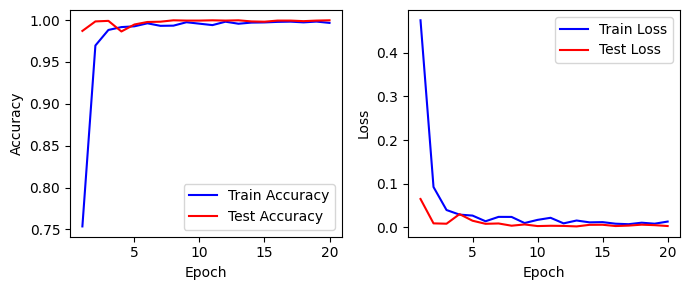

In [9]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1,len(acc)+1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step
Confusion Matrix:
[[1499    1]
 [   0 1500]]


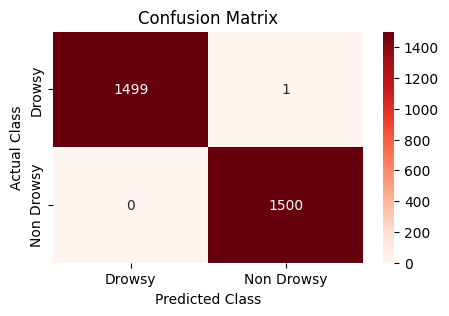


Classification Report:
              precision    recall  f1-score   support

      Drowsy    1.00000   0.99933   0.99967      1500
  Non Drowsy    0.99933   1.00000   0.99967      1500

    accuracy                        0.99967      3000
   macro avg    0.99967   0.99967   0.99967      3000
weighted avg    0.99967   0.99967   0.99967      3000



In [10]:
steps_per_epoch = np.ceil(valid_generator.samples / valid_generator.batch_size).astype(int)
 
# Get predictions from the model
predictions = model2.predict(valid_generator, steps=steps_per_epoch)
 
# Since this is a binary classification, we threshold predictions at 0.5
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
 
# Get the true classes
true_classes = valid_generator.classes
 
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_labels = list(valid_generator.class_indices.keys())
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()
 
# Print the classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(valid_generator.class_indices.keys()), digits=5))

In [11]:
model.save('/kaggle/working/cnn_lstm_model2.h5')

# **Third Architecture**

In [13]:
def build_cnn_lstm_model3(input_shape):
    model3 = Sequential()

    model3.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model3.add(MaxPooling2D((2, 2)))
    model3.add(Conv2D(32, (3, 3), activation='relu'))
    model3.add(MaxPooling2D((2, 2)))
    
    model3.add(TimeDistributed(Flatten()))
    
    model3.add(LSTM(64, return_sequences=True))
    model3.add(LSTM(64, return_sequences=False))

    model3.add(Dense(128, activation='relu'))
    model3.add(Dropout(0.5))
    model3.add(Dense(1, activation='sigmoid'))
    
    return model3

input_shape = (224, 224, 1)
model3 = build_cnn_lstm_model3(input_shape)

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.summary()

log_dir = "./"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history3 = model3.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[tensorboard_callback]
)

# Evaluate the model
test_loss, test_acc = model3.evaluate(valid_generator)
print(f'Test accuracy: {test_acc:.4f}')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 54, 1728)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 54, 64)         │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 510,049 (1.95 MB)

 Trainable params: 510,049 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 130s 283ms/step - accuracy: 0.5610 - loss: 0.7025 - val_accuracy: 0.7467 - val_loss: 0.5360
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 249ms/step - accuracy: 0.7849 - loss: 0.4627 - val_accuracy: 0.9730 - val_loss: 0.1113
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 110s 248ms/step - accuracy: 0.9414 - loss: 0.1585 - val_accuracy: 0.9940 - val_loss: 0.0237
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 249ms/step - accuracy: 0.9733 - loss: 0.0828 - val_accuracy: 0.9957 - val_loss: 0.0154
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 249ms/step - accuracy: 0.9843 - loss: 0.0476 - val_accuracy: 0.9990 - val_loss: 0.0083
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 112s 252ms/step - accuracy: 0.9852 - loss: 0.0487 - val_accuracy: 0.9973 - val_loss: 0.0098
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 112s 252ms/step - accuracy: 0.9910 - loss: 0.0318 - val_accuracy: 0.9980 - val_loss: 0.0106
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 111s 249ms/step - accuracy: 0.9933 -

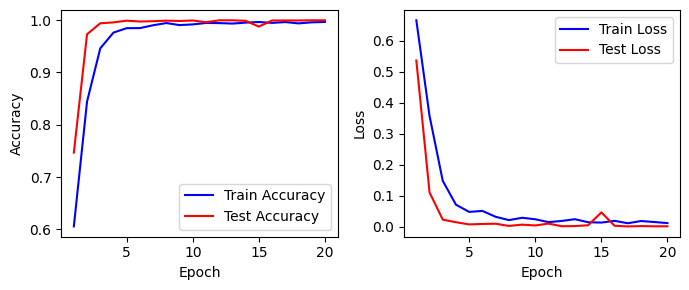

In [14]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1,len(acc)+1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step
Confusion Matrix:
[[1499    1]
 [   0 1500]]


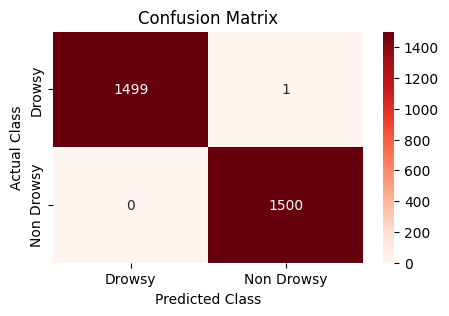


Classification Report:
              precision    recall  f1-score   support

      Drowsy    1.00000   0.99933   0.99967      1500
  Non Drowsy    0.99933   1.00000   0.99967      1500

    accuracy                        0.99967      3000
   macro avg    0.99967   0.99967   0.99967      3000
weighted avg    0.99967   0.99967   0.99967      3000



In [15]:
steps_per_epoch = np.ceil(valid_generator.samples / valid_generator.batch_size).astype(int)
 
# Get predictions from the model
predictions = model3.predict(valid_generator, steps=steps_per_epoch)
 
# Since this is a binary classification, we threshold predictions at 0.5
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
 
# Get the true classes
true_classes = valid_generator.classes
 
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_labels = list(valid_generator.class_indices.keys())
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()
 
# Print the classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(valid_generator.class_indices.keys()), digits=5))

In [16]:
model.save('/kaggle/working/cnn_lstm_model3.h5')

# **Hyperparameter Tuning**

In [3]:
import optuna

# Hyperprameter Tuning
def build_best_arc_model(trial):
    model = Sequential()
    
    model.add(Conv2D(filters=trial.suggest_int('filters_1', 32, 96), 
                     kernel_size=(3, 3), 
                     activation='relu', 
                     input_shape=(224, 224, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=trial.suggest_int('filters_2', 32, 96), 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(filters=trial.suggest_int('filters_3', 32, 96), 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(trial.suggest_int('lstm_units_1', 32, 96), return_sequences=True))
    model.add(LSTM(trial.suggest_int('lstm_units_2', 32, 96), return_sequences=False))
    model.add(Dropout(trial.suggest_float('dropout', 0.2, 0.5)))

    model.add(Dense(1, activation='sigmoid'))
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


def objective(trial):
    best_model = build_best_arc_model(trial)
    
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 96])
    epochs = trial.suggest_categorical('epochs', [20, 30, 40, 50])
    
    log_dir = "./"
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = best_model.fit(
        train_generator,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=valid_generator,
        callbacks=[tensorboard_callback, early_stopping]
    )
    
    val_accuracy = np.mean(history.history['val_accuracy'])
    return val_accuracy
 

# Create a study and optimize
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize', storage='sqlite:///optuna_tuning.db', load_if_exists=True)
study.optimize(objective, n_trials=20)
print('Best hyperparameters:', study.best_params)
print('Best accuracy:', study.best_value)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 214s 462ms/step - accuracy: 0.4948 - loss: 0.6979 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 104s 234ms/step - accuracy: 0.4906 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 102s 229ms/step - accuracy: 0.5059 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 102s 230ms/step - accuracy: 0.4913 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 102s 229ms/step - accuracy: 0.4983 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/30
438/438 ━━━━━━━━━━━━━━━━━━━━ 102s 230ms/step - accuracy: 0.4902 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 113s 240ms/step - accuracy: 0.5730 - loss: 0.6643 - val_accuracy: 0.8143 - val_loss: 0.4288
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 102s 230ms/step - accuracy: 0.8457 - loss: 0.35

In [8]:
def build_cnn_lstm_tuned_model(input_shape):
    tuned_model = Sequential()

    tuned_model.add(Conv2D(33, (3, 3), activation='relu', input_shape=input_shape))
    tuned_model.add(MaxPooling2D((2, 2)))
    tuned_model.add(Conv2D(81, (3, 3), activation='relu'))
    tuned_model.add(MaxPooling2D((2, 2)))
    tuned_model.add(Conv2D(70, (3, 3), activation='relu'))
    tuned_model.add(MaxPooling2D((2, 2)))

    tuned_model.add(TimeDistributed(Flatten()))
    
    tuned_model.add(LSTM(50, return_sequences=True))
    tuned_model.add(LSTM(80, return_sequences=False))
    tuned_model.add(Dropout(0.47))

    tuned_model.add(Dense(1, activation='sigmoid'))
    
    tuned_model.compile(optimizer=Adam(learning_rate=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    
    return tuned_model

input_shape = (224, 224, 1)
tuned_model = build_cnn_lstm_tuned_model(input_shape)

tuned_model.summary()

log_dir = "./"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

tuned_history = tuned_model.fit(
    train_generator,
    epochs=40,
    batch_size=32,
    validation_data=valid_generator,
    callbacks=[tensorboard_callback]
)

# Evaluate the model
test_loss, test_acc = tuned_model.evaluate(valid_generator)
print(f'Validation accuracy: {test_acc:.4f}')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 33)   │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 33)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 81)   │        24,138 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 81)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 70)     │        51,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 26, 1820)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 26, 50)         │       374,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 80)             │        41,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,769 (1.88 MB)

 Trainable params: 491,769 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 127s 280ms/step - accuracy: 0.6246 - loss: 0.6133 - val_accuracy: 0.9903 - val_loss: 0.0569
Epoch 2/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 124s 280ms/step - accuracy: 0.9633 - loss: 0.1065 - val_accuracy: 0.9910 - val_loss: 0.0248
Epoch 3/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 141s 278ms/step - accuracy: 0.9832 - loss: 0.0512 - val_accuracy: 0.9990 - val_loss: 0.0079
Epoch 4/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 124s 279ms/step - accuracy: 0.9903 - loss: 0.0314 - val_accuracy: 0.9997 - val_loss: 0.0032
Epoch 5/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 124s 279ms/step - accuracy: 0.9932 - loss: 0.0234 - val_accuracy: 0.9993 - val_loss: 0.0040
Epoch 6/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 125s 280ms/step - accuracy: 0.9950 - loss: 0.0177 - val_accuracy: 0.9987 - val_loss: 0.0063
Epoch 7/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 124s 278ms/step - accuracy: 0.9965 - loss: 0.0134 - val_accuracy: 0.9987 - val_loss: 0.0058
Epoch 8/40
438/438 ━━━━━━━━━━━━━━━━━━━━ 124s 279ms/step - accuracy: 0.9954 -

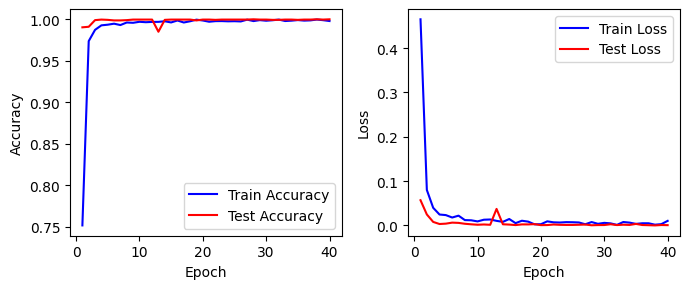

In [9]:
acc = tuned_history.history['accuracy']
val_acc = tuned_history.history['val_accuracy']
loss = tuned_history.history['loss']
val_loss = tuned_history.history['val_loss']

epochs = range(1,len(acc)+1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss,'b',label='Train Loss')
axes[1].plot(epochs, val_loss,'r',label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step
Confusion Matrix:
[[1500    0]
 [   0 1500]]


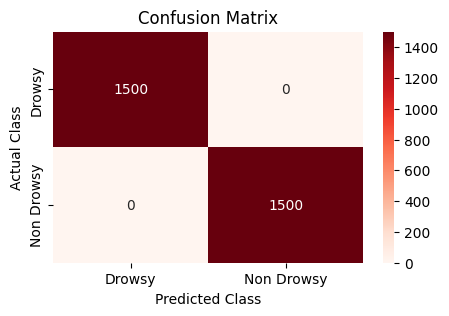


Classification Report:
              precision    recall  f1-score   support

      Drowsy    1.00000   1.00000   1.00000      1500
  Non Drowsy    1.00000   1.00000   1.00000      1500

    accuracy                        1.00000      3000
   macro avg    1.00000   1.00000   1.00000      3000
weighted avg    1.00000   1.00000   1.00000      3000



In [10]:
steps_per_epoch = np.ceil(valid_generator.samples / valid_generator.batch_size).astype(int)
 
# Get predictions from the model
predictions = tuned_model.predict(valid_generator, steps=steps_per_epoch)
 
# Since this is a binary classification, we threshold predictions at 0.5
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)
 
# Get the true classes
true_classes = valid_generator.classes
 
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Plot confusion matrix
plt.figure(figsize=(5, 3))
class_labels = list(valid_generator.class_indices.keys())
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()
 
# Print the classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(valid_generator.class_indices.keys()), digits=5))

In [5]:
tuned_model.save('/kaggle/working/cnn_lstm_tuned_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step


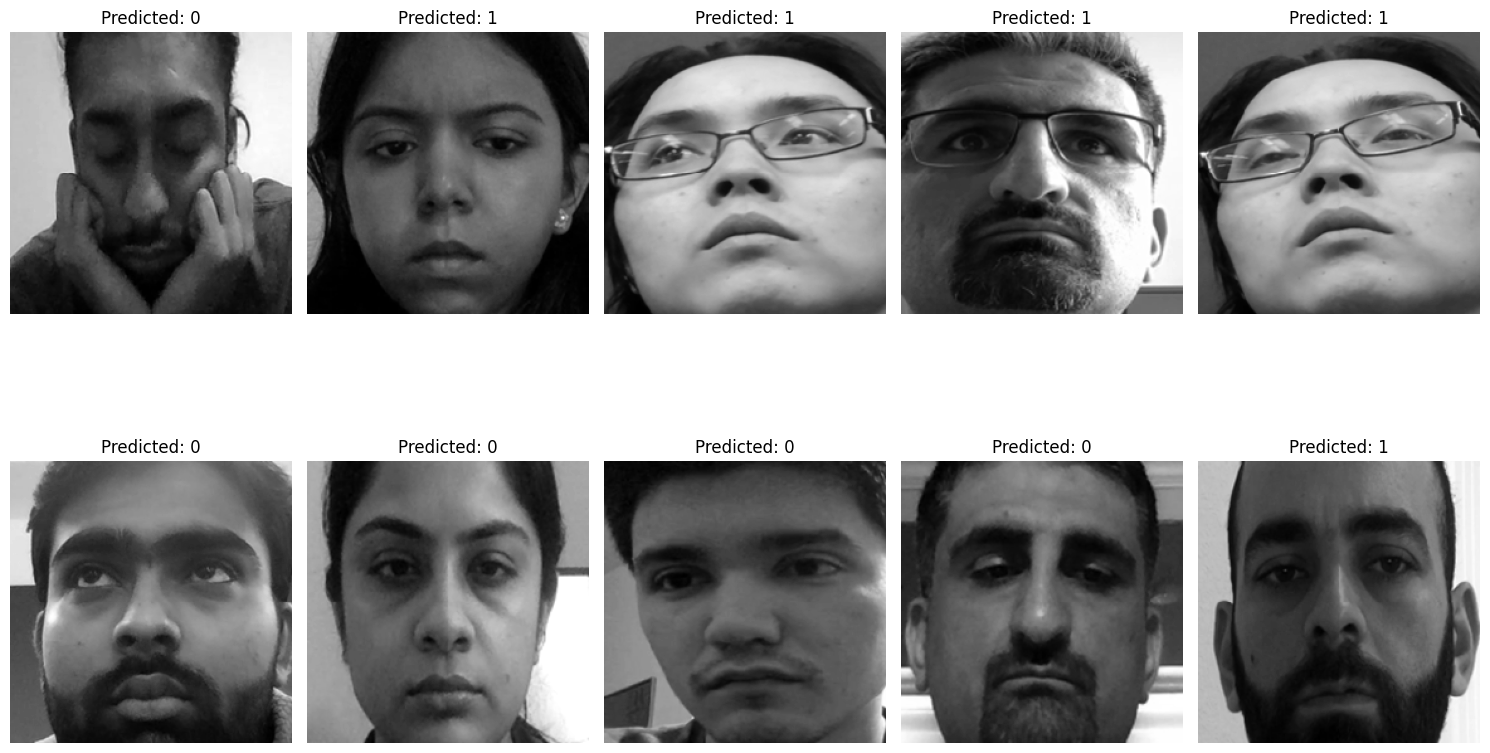

In [6]:
images, labels = next(test_generator)
first_10_images = images[:10]

predictions = tuned_model.predict(first_10_images)
predicted_classes = np.argmax(predictions, axis=1) if test_generator.class_mode != 'binary' else (predictions > 0.5).astype('int32')
predicted_classes = predicted_classes.flatten()
 
plt.figure(figsize=(15, 10))
for i in range(len(first_10_images)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(first_10_images[i].squeeze(), cmap='gray')
    plt.title(f"Predicted: {predicted_classes[i]}")
    plt.axis('off')
 
plt.tight_layout()
plt.show()